# Laplacian Pyramid Comparison of SVG Circles

This notebook demonstrates generating SVG circles and comparing them using Laplacian pyramid distance.


In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Add parent directory to path to import local modules
sys.path.append('..')

# Set DreamSim cache directory to use the project's models directory
os.environ['DREAMSIM_CACHE_DIR'] = '../models'

from prefixrl.reward.image.laplacian import (
    compare_images_by_laplacian,
    laplacian_pyramid,
)
from prefixrl.reward.image.l2 import compare_images_by_l2
from prefixrl.reward.image.dreamsim import compare_images_by_dreamsim
from prefixrl.reward.image.util import pil_to_tensor
from prefixrl.reward.svg.cairosvg import rasterize_svg
from prefixrl.reward.svg.shapes import make_circle, make_line, make_rectangle

# if we only care about the image, we can use this shortcut
def rasterize(svg: str):
    img, _, _ = rasterize_svg(svg)
    return img

print(f"Using python '{sys.version}'")
print(f"Using torch '{torch.__version__}'")


Using python '3.12.10 (main, Apr  9 2025, 03:49:38) [Clang 20.1.0 ]'
Using torch '2.7.0'


In [ ]:
# prewarm comparator so it doesn't spew later
_im = rasterize(make_circle(r=150, fill="white", stroke="grey", stroke_width=10, background="white"))
_ = compare_images_by_dreamsim(_im, _im)

Generate charts for comparing different metrics with SVGs along a single parameter axis.

/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_1701/558484028.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


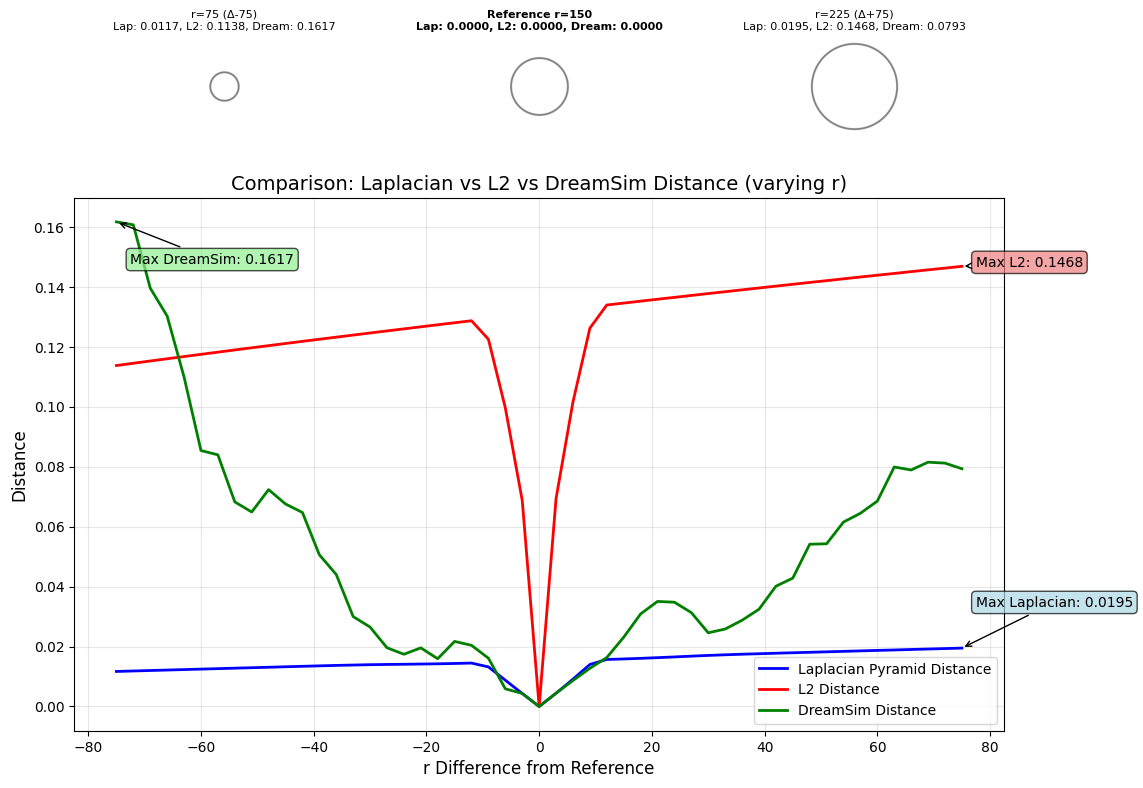

In [68]:
def compare_svg_parameter_distances(shape_func, param_values, reference_value, param_name, 
                                  example_values=None, figsize=(12, 9)):
    """
    Compare Laplacian pyramid, L2, and DreamSim distances for different parameter values of an SVG shape.
    
    Args:
        shape_func: Function that takes a parameter value and returns SVG string
        param_values: List of parameter values to test
        reference_value: Reference parameter value for comparison
        param_name: Name of the parameter being varied (for labels)
        example_values: Optional list of 3 values to show as examples (defaults to [min, ref, max])
        figsize: Figure size tuple
    
    Returns:
        tuple: (param_differences, laplacian_distances, l2_distances, dreamsim_distances)
    """
    from matplotlib.gridspec import GridSpec
    
    # Ensure reference value is in the test values
    if reference_value not in param_values:
        param_values = list(param_values) + [reference_value]
        param_values.sort()
    
    # Create reference image
    img_ref = rasterize(shape_func(reference_value))
    
    # Compute distances for all parameter values
    laplacian_distances = []
    l2_distances = []
    dreamsim_distances = []
    
    for param_val in param_values:
        svg = shape_func(param_val)
        img = rasterize(svg)
        
        laplacian_dist = compare_images_by_laplacian(img, img_ref)
        l2_dist = compare_images_by_l2(img, img_ref)
        dreamsim_dist = compare_images_by_dreamsim(img, img_ref)
        
        laplacian_distances.append(laplacian_dist)
        l2_distances.append(l2_dist)
        dreamsim_distances.append(dreamsim_dist)
    
    # Choose example values for display
    if example_values is None:
        example_values = [min(param_values), reference_value, max(param_values)]
    
    # Generate example images and distances
    example_images = []
    example_laplacian_distances = []
    example_l2_distances = []
    example_dreamsim_distances = []
    for val in example_values:
        svg = shape_func(val)
        img = rasterize(svg)
        example_images.append(img)
        
        lap_dist = compare_images_by_laplacian(img, img_ref)
        l2_dist = compare_images_by_l2(img, img_ref)
        dreamsim_dist = compare_images_by_dreamsim(img, img_ref)
        example_laplacian_distances.append(lap_dist)
        example_l2_distances.append(l2_dist)
        example_dreamsim_distances.append(dreamsim_dist)
    
    # Create visualization
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 3, figure=fig, height_ratios=[0.4, 2.2], hspace=0.2, wspace=0.05)
    
    # Top row: 3 example shapes
    for i, (val, img, lap_dist, l2_dist, dream_dist) in enumerate(zip(example_values, example_images, example_laplacian_distances, example_l2_distances, example_dreamsim_distances)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(img)
        param_diff = val - reference_value
        if val == reference_value:
            ax.set_title(f"Reference {param_name}={val}\nLap: {lap_dist:.4f}, L2: {l2_dist:.4f}, Dream: {dream_dist:.4f}", fontweight='bold', fontsize=8)
        else:
            ax.set_title(f"{param_name}={val} (Δ{param_diff:+})\nLap: {lap_dist:.4f}, L2: {l2_dist:.4f}, Dream: {dream_dist:.4f}", fontsize=8)
        ax.axis('off')
    
    # Bottom: Main comparison graph
    ax_main = fig.add_subplot(gs[1, :])
    param_diff = [val - reference_value for val in param_values]
    
    # Plot all three distance metrics
    ax_main.plot(param_diff, laplacian_distances, 'b-', linewidth=2, label='Laplacian Pyramid Distance')
    ax_main.plot(param_diff, l2_distances, 'r-', linewidth=2, label='L2 Distance')
    ax_main.plot(param_diff, dreamsim_distances, 'g-', linewidth=2, label='DreamSim Distance')
    
    ax_main.set_xlabel(f"{param_name} Difference from Reference", fontsize=12)
    ax_main.set_ylabel("Distance", fontsize=12)
    ax_main.set_title(f"Comparison: Laplacian vs L2 vs DreamSim Distance (varying {param_name})", fontsize=14)
    ax_main.grid(True, alpha=0.3)
    ax_main.legend()
    
    # Add annotations for key points
    max_lap_idx = np.argmax(laplacian_distances)
    max_l2_idx = np.argmax(l2_distances)
    max_dream_idx = np.argmax(dreamsim_distances)
    
    ax_main.annotate(f'Max Laplacian: {laplacian_distances[max_lap_idx]:.4f}', 
                    xy=(param_diff[max_lap_idx], laplacian_distances[max_lap_idx]),
                    xytext=(10, 30), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    ax_main.annotate(f'Max L2: {l2_distances[max_l2_idx]:.4f}', 
                    xy=(param_diff[max_l2_idx], l2_distances[max_l2_idx]),
                    xytext=(10, 0), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    ax_main.annotate(f'Max DreamSim: {dreamsim_distances[max_dream_idx]:.4f}', 
                    xy=(param_diff[max_dream_idx], dreamsim_distances[max_dream_idx]),
                    xytext=(10, -30), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.show()
    
    # return param_diff, laplacian_distances, l2_distances, dreamsim_distances

# ------------------------------------------------------------------------------------------------

compare_svg_parameter_distances(
    shape_func=lambda r: make_circle(r=r, fill="white", stroke="grey", stroke_width=10, background="white"),
    param_values=range(75, 226, 3),
    reference_value=150,
    param_name="r",
    example_values=[75, 150, 225],
)


### Individual shape tests

/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_1701/558484028.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


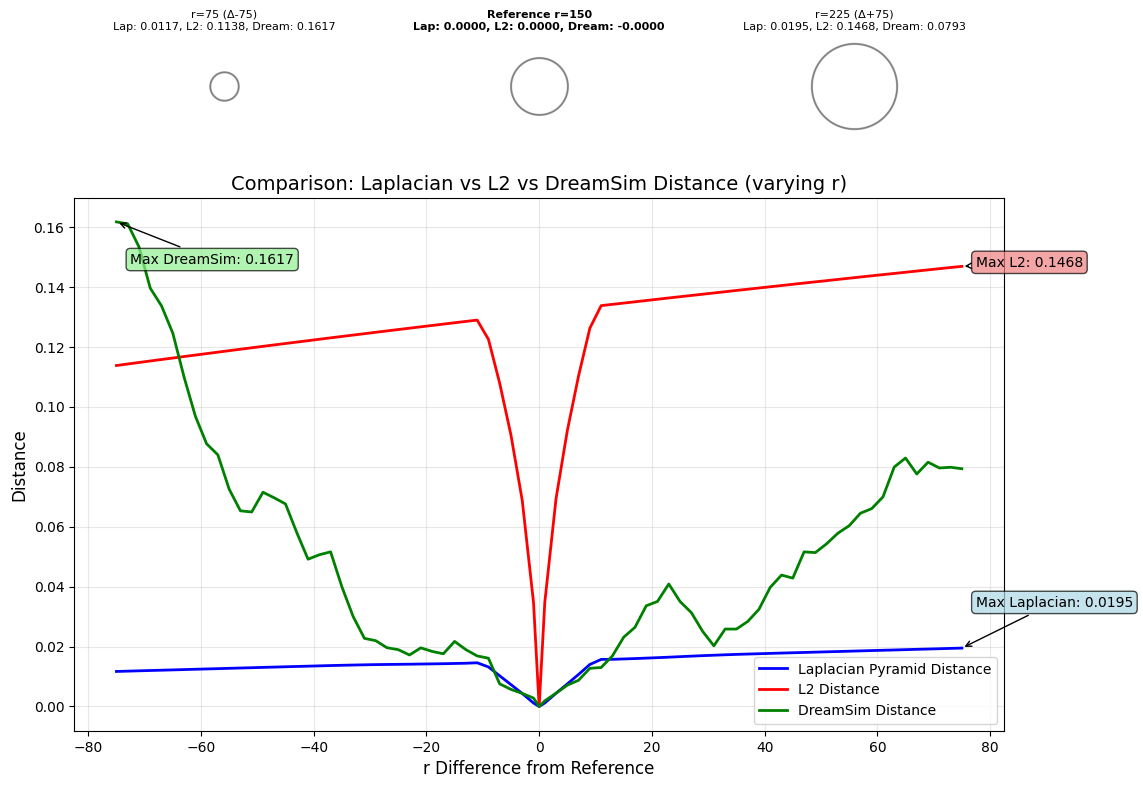

In [81]:
compare_svg_parameter_distances(
    shape_func=lambda r: make_circle(r=r, fill="white", stroke="grey", stroke_width=10, background="white"),
    param_values=np.arange(75, 226, 2),
    reference_value=150,
    param_name="r",
    example_values=[75, 150, 225],
)

Using cached ../models


Using cache found in ../models/facebookresearch_dino_main
/Users/andrew/Developer/Prefix/prefix-rl/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/Users/andrew/Developer/Prefix/prefix-rl/.venv/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_1701/558484028.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


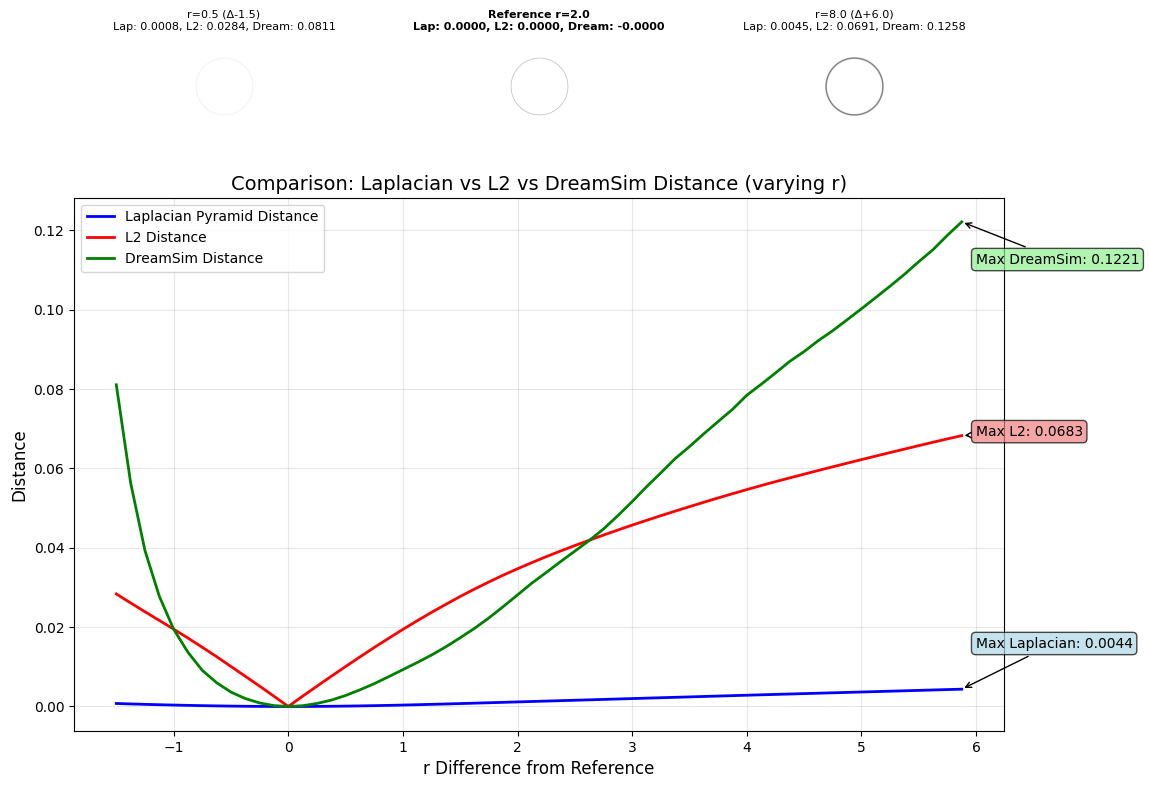

In [75]:
compare_svg_parameter_distances(
    shape_func=lambda w: make_circle(
        r=150, fill="white", stroke="grey", stroke_width=w, background="white"
    ),
    param_values=np.arange(0.5, 8.0, 0.125),
    reference_value=2.0,
    param_name="r",
    example_values=[0.5, 2.0, 8.0],
)


/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_1701/558484028.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


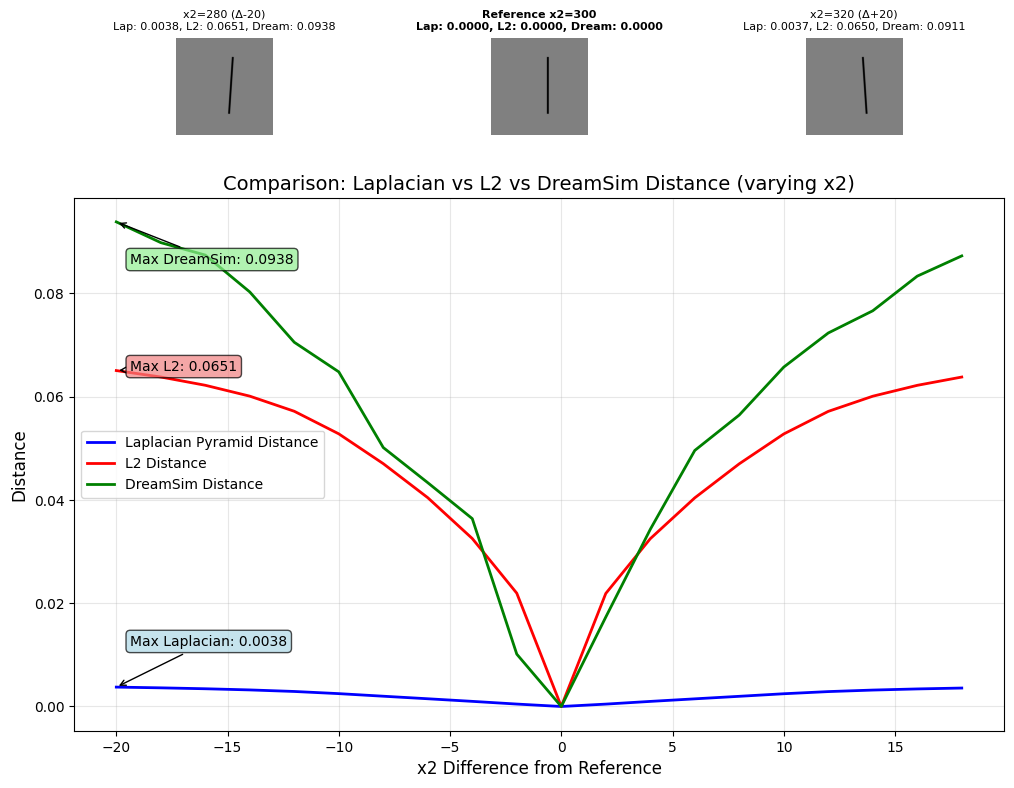

In [71]:
compare_svg_parameter_distances(
    shape_func=lambda x: make_line(x1=300, y1=100, x2=x, y2=400, stroke_width=10, background="gray"),
    param_values=range(300-20, 300+20, 2),
    reference_value=300,
    param_name="x2",
    example_values=[300-20, 300, 300+20],
)

/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_1701/558484028.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


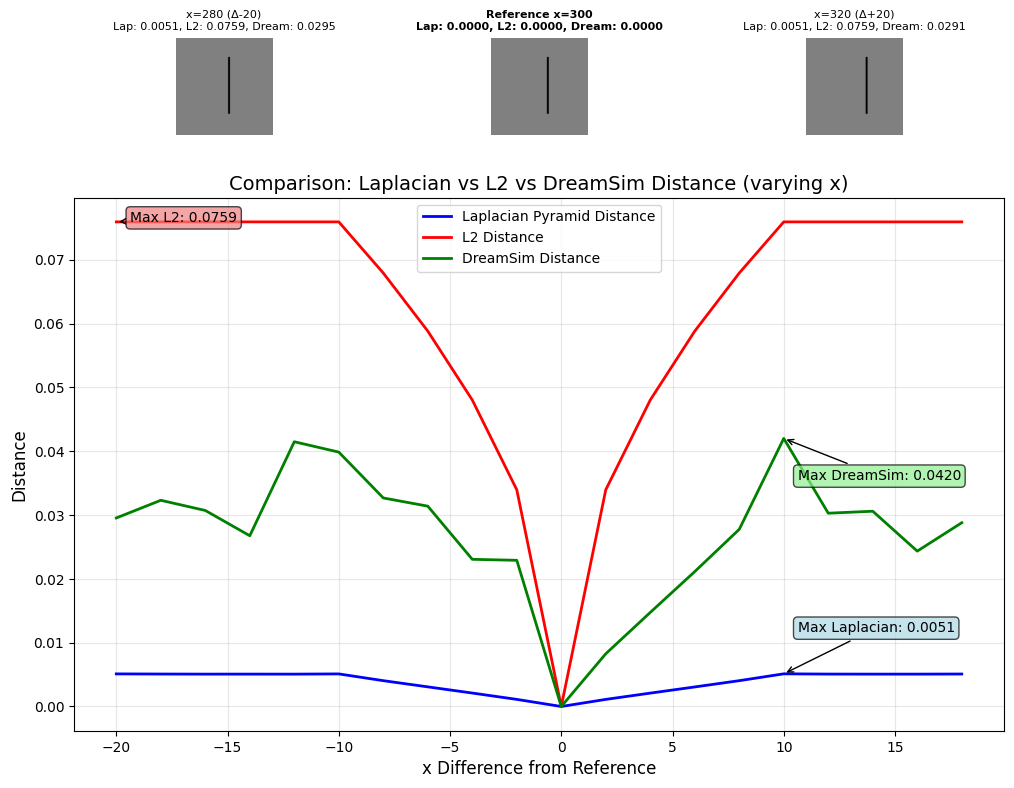

In [72]:
compare_svg_parameter_distances(
    shape_func=lambda x: make_line(
        x1=x, y1=100, x2=x, y2=400, stroke_width=10, background="gray"
    ),
    param_values=range(300 - 20, 300 + 20, 2),
    reference_value=300,
    param_name="x",
    example_values=[300 - 20, 300, 300 + 20],
)


/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_1701/558484028.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


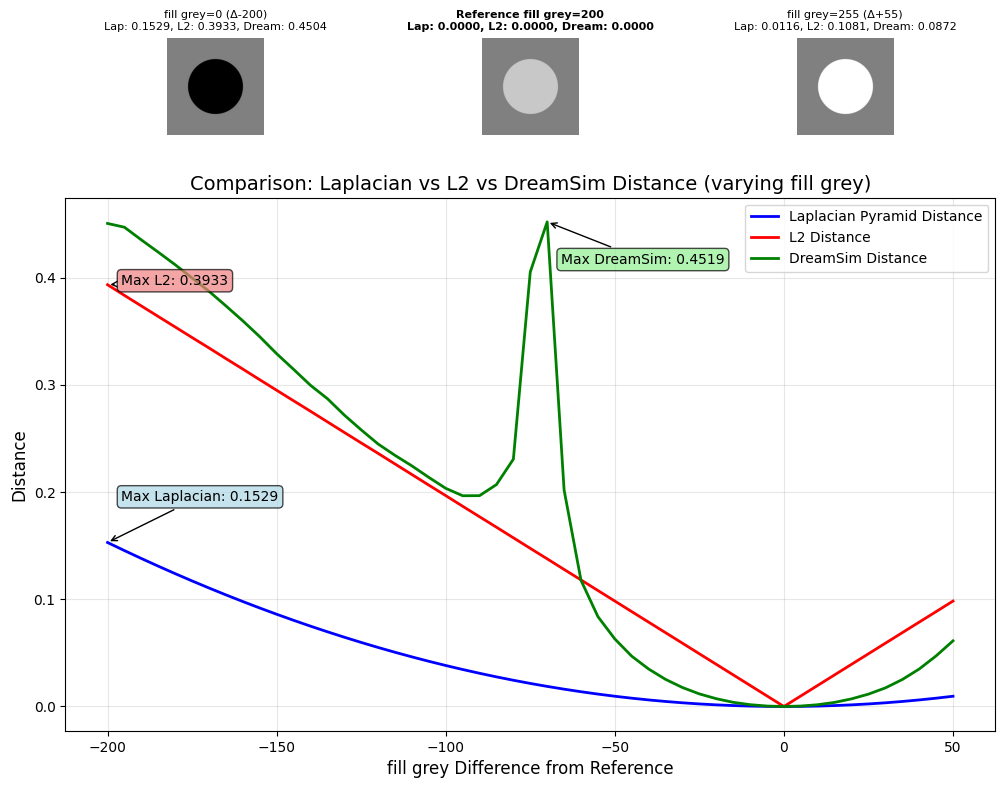

In [80]:
compare_svg_parameter_distances(
    shape_func=lambda bg: make_circle(
        r=150,
        fill=f"#{int(bg):02x}{int(bg):02x}{int(bg):02x}",
        stroke="grey",
        stroke_width=10,
        background="gray",
    ),
    param_values=np.arange(0, 255, 5),
    reference_value=200,
    param_name="fill grey",
    example_values=[0, 200, 255],
)


There is a spike in the DreamSim distance at 128, where the image becomes a solid color. This is actually desired behavior, as humans would perceive the image as more dissimilar to the reference image.

## Laplacian Tree Visualization

Visualize the hierarchical structure of the Laplacian pyramid as a tree, showing how information flows from fine to coarse scales.


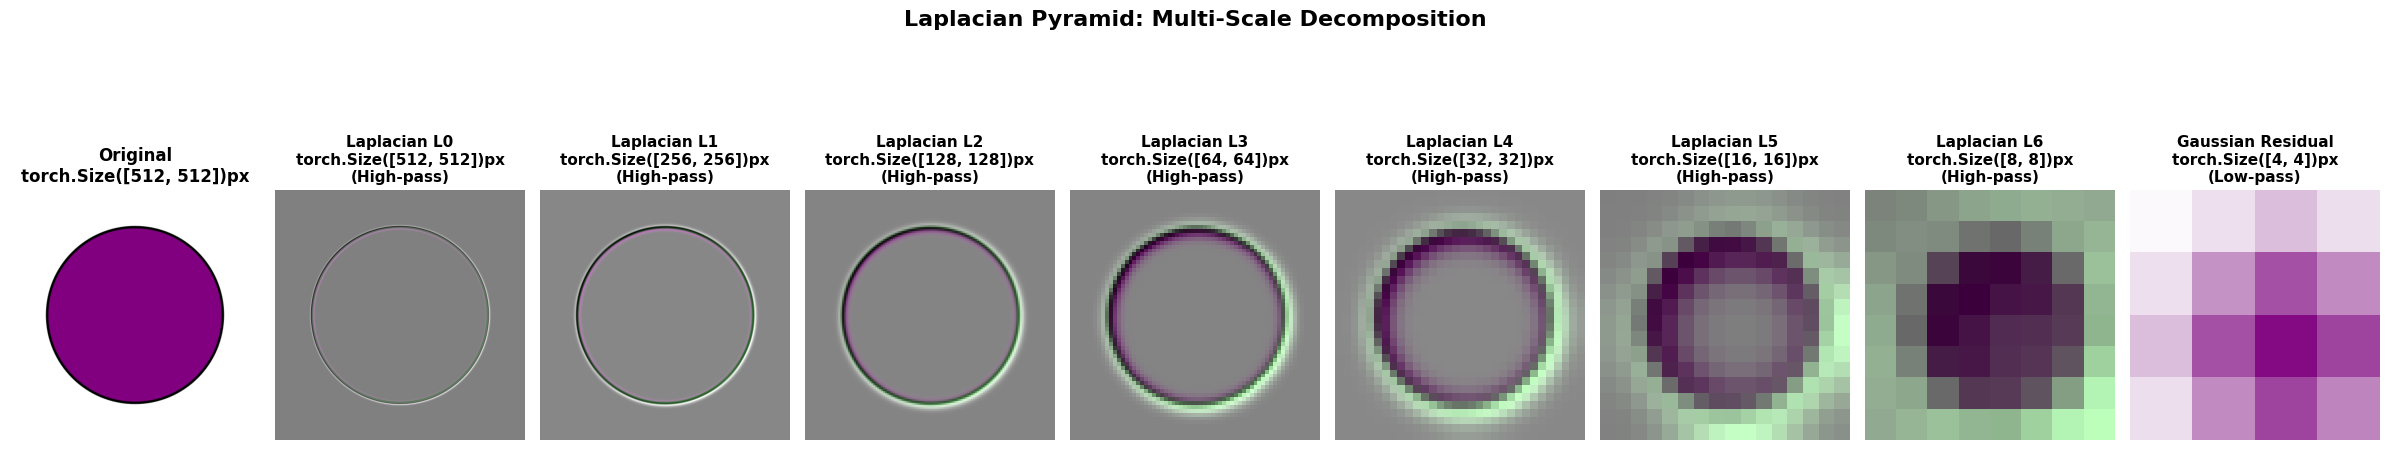

Pyramid Level Statistics:
--------------------------------------------------
Level 0 (Laplacian):
  Shape: torch.Size([1, 3, 512, 512])
  Range: [-0.5235, 0.5147]
  Mean: 0.0000, Std: 0.0399

Level 1 (Laplacian):
  Shape: torch.Size([1, 3, 256, 256])
  Range: [-0.4645, 0.4094]
  Mean: 0.0000, Std: 0.0505

Level 2 (Laplacian):
  Shape: torch.Size([1, 3, 128, 128])
  Range: [-0.4241, 0.3912]
  Mean: 0.0000, Std: 0.0589

Level 3 (Laplacian):
  Shape: torch.Size([1, 3, 64, 64])
  Range: [-0.4114, 0.3822]
  Mean: 0.0000, Std: 0.0687

Level 4 (Laplacian):
  Shape: torch.Size([1, 3, 32, 32])
  Range: [-0.4231, 0.3653]
  Mean: 0.0004, Std: 0.0899

Level 5 (Laplacian):
  Shape: torch.Size([1, 3, 16, 16])
  Range: [-0.4401, 0.4375]
  Mean: 0.0051, Std: 0.1374

Level 6 (Laplacian):
  Shape: torch.Size([1, 3, 8, 8])
  Range: [-0.4681, 0.5826]
  Mean: 0.0189, Std: 0.1999

Level 7 (Gaussian Residual):
  Shape: torch.Size([1, 3, 4, 4])
  Range: [0.0405, 0.9880]
  Mean: 0.7166, Std: 0.2165



In [74]:
def visualize_laplacian_pyramid_horizontal(img, levels=4, figsize=(18, 6), padding_mode="reflect"):
    """
    Visualize the Laplacian pyramid in a simple horizontal row layout.
    All images are displayed at the same size for easy comparison.
    
    Args:
        img: PIL Image or torch tensor
        levels: Number of pyramid levels
        figsize: Figure size tuple
        padding_mode: Padding mode for convolutions ("zeros", "reflect", "replicate", "circular")
    """
    # Convert to tensor if needed
    if isinstance(img, Image.Image):
        img_tensor = pil_to_tensor(img).unsqueeze(0)
    else:
        img_tensor = img
    
    # Compute Laplacian pyramid with configurable padding
    pyramid = laplacian_pyramid(img_tensor, levels=levels, padding_mode=padding_mode)
    
    # Create horizontal subplot layout: Original + Laplacian levels + Gaussian residual
    n_plots = 1 + len(pyramid)  # Original + all pyramid levels
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    # Original image
    if isinstance(img, Image.Image):
        axes[0].imshow(img)
    else:
        img_np = img_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
        axes[0].imshow(img_np)
    axes[0].set_title(f"Original\n{img_tensor.shape[-2:]}px", fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Laplacian levels and Gaussian residual
    colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown', 'pink', 'gray']
    
    for i, level in enumerate(pyramid):
        ax_idx = i + 1
        level_np = level.squeeze().permute(1, 2, 0).detach().cpu().numpy()
        
        if i < len(pyramid) - 1:  # Laplacian levels
            # Normalize for better visualization
            level_np = (level_np - level_np.min()) / (level_np.max() - level_np.min() + 1e-8)
            axes[ax_idx].imshow(level_np, cmap='RdBu_r')
            axes[ax_idx].set_title(f"Laplacian L{i}\n{level.shape[-2:]}px\n(High-pass)", 
                                 fontsize=11, fontweight='bold')
            # Add colored border
            color = colors[i % len(colors)]
            for spine in axes[ax_idx].spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(3)
                spine.set_visible(True)
        else:  # Gaussian residual
            axes[ax_idx].imshow(level_np)
            axes[ax_idx].set_title(f"Gaussian Residual\n{level.shape[-2:]}px\n(Low-pass)", 
                                 fontsize=11, fontweight='bold')
            # Add border for residual
            for spine in axes[ax_idx].spines.values():
                spine.set_edgecolor('darkblue')
                spine.set_linewidth(3)
                spine.set_visible(True)
        
        axes[ax_idx].axis('off')
    
    plt.suptitle("Laplacian Pyramid: Multi-Scale Decomposition", 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig, pyramid

# Test the visualization with a circle
svg = make_circle(r=180, fill="purple", stroke_width=5)
img, _, _ = rasterize_svg(svg)

# Use more levels to get down to ~4x4 residual
# 512 -> 256 -> 128 -> 64 -> 32 -> 16 -> 8 -> 4
fig, pyramid_data = visualize_laplacian_pyramid_horizontal(img, levels=8, figsize=(24, 6))
plt.show()

# Print pyramid statistics
print("Pyramid Level Statistics:")
print("-" * 50)
for i, level in enumerate(pyramid_data):
    level_type = "Laplacian" if i < len(pyramid_data) - 1 else "Gaussian Residual"
    shape = level.shape
    min_val = level.min().item()
    max_val = level.max().item()
    mean_val = level.mean().item()
    std_val = level.std().item()
    
    print(f"Level {i} ({level_type}):")
    print(f"  Shape: {shape}")
    print(f"  Range: [{min_val:.4f}, {max_val:.4f}]")
    print(f"  Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    print()
